<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
%matplotlib inline

plt.style.use(['science','grid'])

In [3]:
def plot1(x, y, label_x, label_y, title=None, legend=None, save=None):
    fig, ax = plt.subplots(figsize=(7,5))
    for i in enumerate(x):
        ax.plot(x[i[0]], y[i[0]], 'r')
    ax.set_xlabel(label_x, fontsize=16)
    ax.set_ylabel(label_y, fontsize=16)
    if title != None: ax.set_title(title)
    if legend != None: ax.legend(legend)
    plt.savefig('loss.png',dpi=800)
    plt.show()

In [4]:
import torch
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


I'm going to try and use the difference at dx and the expected profile for a pressure gradient as a parameter, as well as the first order FD. This could be good as they both depend on the resolution and the pressure gradient.

In [5]:
pol_dx = lambda eta, lam: 2 * eta - 2 * eta**3 + eta**4 + lam * eta / 6 * (
    1 - eta)**3
dx = torch.tensor(np.array([1 / 10**n for n in np.linspace(0.3, 1.5, 51)]),
                  device=device)
lam = torch.tensor(np.linspace(-30, 30, 51), device=device)
# Create square matrices
dx = torch.tensor(np.ones((len(lam), 1)), device=device) * dx
lam = (torch.tensor(np.ones((len(dx), 1)), device=device) * lam).t()

torch.cuda.empty_cache()
# Assign velocities and gradient
u1_x = pol_dx(dx, lam)
u2_x = pol_dx(2 * dx, lam)

mu_0 = lambda d: 0.5 * (1 + d / (2) + 1 / np.pi * np.sin(d / (2) * np.pi))
mu_1 = lambda d: 2*(1/4-(d/(2*2))**2 -\
                 1/(2*np.pi)\
                 *(d/2 * np.sin(d*np.pi/2)\
                   + 1/np.pi*(1+np.cos(d*np.pi/2))))

# Define smoothed value and 1st order finite difference
s_u1_x = u1_x; df = (u2_x-s_u1_x) / dx
for i in range(100):
    s_u1_x = s_u1_x * mu_0(1) +  df * mu_1(1)*dx
    df = (u2_x-s_u1_x) / dx

fd_1 = (u2_x / (2*dx))
exact = 2 + lam/6
diff_dx = s_u1_x - u1_x

del s_u1_x,u1_x, u2_x, pol_dx, mu_0, mu_1,dx
torch.cuda.empty_cache()

In [6]:
exact = exact.t().reshape([1,exact.size()[0]**2])[0]
lam = lam.t().reshape([1,lam.size()[0]**2])[0]
fd_1 = fd_1.t().reshape([1,fd_1.size()[0]**2])[0]
diff_dx = diff_dx.t().reshape([1,diff_dx.size()[0]**2])[0]

my_data = torch.stack((lam, fd_1, diff_dx,exact), dim=1)
my_data = my_data.cpu().numpy()

In [7]:
my_data = pd.DataFrame(my_data, columns=['lam', 'fd', 'diff_dx', 'exact'])

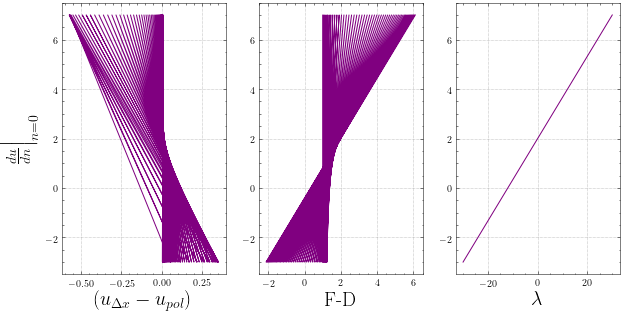

In [8]:
fig,ax = plt.subplots(1,3,figsize =(10,5),sharey=False)
ax[0].set_ylabel(r'$\frac{du}{dn}\Big|_{n=0}$',fontsize=20, rotation=90)
ax[0].set_xlabel(r'$(u_{\Delta x}-u_{pol})$', rotation=0,fontsize=20)
ax[1].set_xlabel(r'F-D', rotation=0,fontsize=20)
ax[2].set_xlabel(r'$\lambda$', rotation=0,fontsize=20)

ax[0].plot(my_data['diff_dx'], my_data['exact'],c='purple')
ax[1].plot(my_data['fd'], my_data['exact'],c='purple')
ax[2].plot(my_data['lam'], my_data['exact'],c='purple')

plt.show()

In [9]:
# cent = pd.DataFrame()
# cent['lam'] = my_data['lam']-my_data['lam'].mean()
# cent['fd'] = my_data['fd']-my_data['fd'].mean()
# cent['err'] = my_data['err']-my_data['err'].mean()
# lam_mean = my_data['lam'].mean(); fd_mean = my_data['fd'].mean(); err_mean = my_data['err'].mean()
# print(f'lam_mean={lam_mean}; fd_mean={fd_mean}; err_mean={err_mean}')

In [10]:
D = torch.tensor(my_data.values, dtype=torch.float, device=device)
x_dataset = D[:, 0:3].t()
y_dataset = D[:, 3].t()

In [11]:
a = 0.0; b = 1.485979676246643; c = -8.860591888427734; d = -0.8082035779953003

In [12]:
LEARNING_RATE = 1e-4
NUM_ITERS = int(3e4)
OPTIMIZER_CONSTRUCTOR = optim.Adam

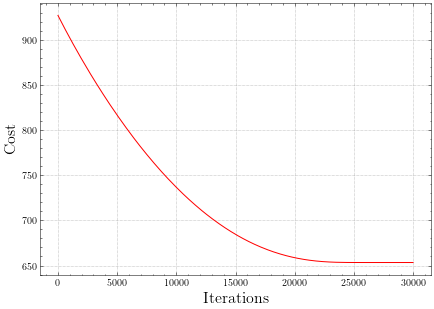

t = 29999, loss = 653.3162841796875, a = 0.0; b = 1.4576131105422974; c = -10.980982780456543; d = -0.8067317605018616


In [13]:
# Provide some initial guesses from the visualisation
coeffs = a,b,c,d; t_coeffs =[]
for i in coeffs:
    t_coeffs.append(torch.tensor(i, requires_grad=True, device=device))
a,b,c,d = t_coeffs

# Define the prediction model
def model(x_input):
    lam,fd,diff = x_input
    return a*lam + b*fd + c * diff + d

# Loss function definition

def loss(y_predicted, y_target):
    return ((y_predicted - y_target)**2).sum()

# Setup the optimizer object, so it optimizes a and b.
optimizer = OPTIMIZER_CONSTRUCTOR([b,c,d], lr=LEARNING_RATE)         #  <----------

# Main optimization loop
cost=[]
for t in range(NUM_ITERS):
    optimizer.zero_grad()                        # Set the gradients to 0.
    y_predicted = model(x_dataset)               # Compute the current predicted y's from x_dataset
    current_loss = loss(y_predicted, y_dataset)  # See how far off the prediction is
    cost.append(current_loss)
    current_loss.backward()                      # Compute the gradient of the loss with respect to A and b.
    optimizer.step()                             # Update A and b accordingly.
plot1([np.arange(NUM_ITERS)], [cost], 'Iterations', 'Cost')
print(
    f"t = {t}, loss = {current_loss}, a = {a.item()}; b = {b.item()}; c = {c.item()}; d = {d.item()}"
    )
a = a.item(); b = b.item(); c = c.item(); d = d.item()

In [14]:
def model(x_input):
    lam,fd,diff = x_input
    return a * lam + b*fd + c * diff + d
# a = 0.0; b = 1.4576115608215332; c = -10.981008529663086; d = -0.8067328929901123

In [15]:
def pol(eta, lam):
    if eta < 0:
        return 0
    elif eta > 1:
        return 1
    else:
        return 2 * eta - 2 * eta**3 + eta**4 + lam * eta / 6 * (1 - eta)**3


def kern(d, eps=2):
    if abs(d) > eps:
        return 0
    else:
        return 0.5 * (1. + np.cos(d * np.pi / eps)) / eps


def mu_0(d, eps=2):
    if d > eps:
        return 1
    elif d < -eps:
        return 0
    else:
        return 0.5 * (1 + d / (eps) + 1 / np.pi * np.sin(d / (eps) * np.pi))


def mu_1(d, eps=2):
    if abs(d) > eps:
        return 0
    else:
        return eps*(1/4-(d/(2*eps))**2 -\
                 1/(2*np.pi)\
                 *(d/eps * np.sin(d*np.pi/eps)\
                   + 1/np.pi*(1+np.cos(d*np.pi/eps))))
    
def sm_pol(dx, lam, t=100):
    # Initialise arrays dx=\delta / n
    eta = np.append(np.arange(-8,dx,dx)[:-1],np.arange(0,8+dx,dx))
    df = np.gradient(np.array([pol(eta,lam) for eta in eta]))/dx
    f = np.array([pol(eta,lam) for eta in eta])
    mu0 = np.array([mu_0(eta,2*dx) for eta in eta])
    mu1 = np.array([mu_1(eta,2*dx) for eta in eta])
    
    # Smooth profile
    n=0
    while n<t:
        u_eps = f*mu0 + df*mu1
        f = u_eps; df = np.gradient(u_eps)/dx
        n+=1
    else:
        u_eps=f
    return u_eps

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


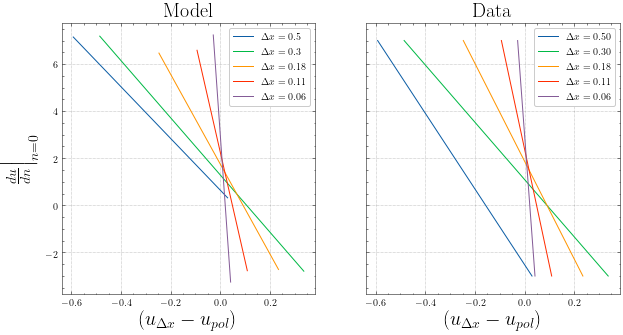

In [16]:
fig,ax = plt.subplots(1,2,figsize =(10,5),sharey=True)
ax[0].set_ylabel(r'$\frac{du}{dn}\Big|_{n=0}$',fontsize=20)
ax[0].set_xlabel(r'$(u_{\Delta x}-u_{pol})$', rotation=0,fontsize=20)
ax[1].set_xlabel(r'$(u_{\Delta x}-u_{pol})$', rotation=0,fontsize=20)

x = np.array([1 / 10**n for n in np.linspace(0.3, 1.2, 5)])
la = np.linspace(-30,30,51)
for dx in x:
    diff_tmp=np.array([]); fd_1_tmp = np.array([]); mod = np.array([]); exact_tmp=np.array([])
    for lam in la:
        eta = np.append(np.arange(-8,dx,dx)[:-1],np.arange(0,8+dx,dx))
        u1_x, u2_x = sm_pol(dx,lam)[np.logical_or(eta == dx, eta == 2*dx)]
        fd = u2_x/(2*dx)
        diff=(u1_x-pol(dx,lam))
        mod = np.append(mod, model([lam,fd,diff]))
        fd_1_tmp = np.append(fd_1_tmp, fd)
        diff_tmp=np.append(diff_tmp,(u1_x-pol(dx,lam)))
        exact_tmp = np.append(exact_tmp, 2+lam/6)
    ax[0].plot(diff_tmp,mod,label=f'$\Delta x  = {round(dx,2)}$')
    ax[0].set_title('Model',fontsize=20)
    ax[1].plot(diff_tmp,exact_tmp,label=r'$\Delta x = {:.2f}$'.format(dx))
    ax[1].set_title('Data',fontsize=20)
ax[0].legend()
ax[1].legend()
# plt.savefig('lambda_dependance.png', dpi=800)
plt.show()

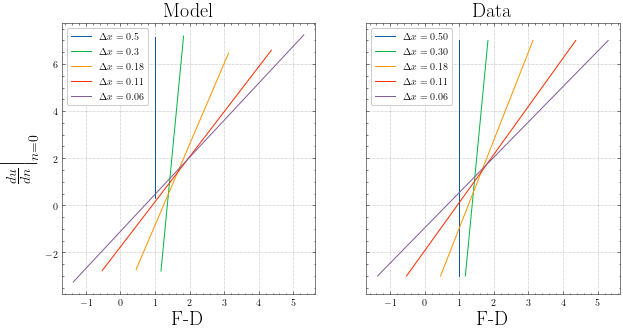

In [17]:
fig,ax = plt.subplots(1,2,figsize =(10,5),sharey=True)
ax[0].set_ylabel(r'$\frac{du}{dn}\Big|_{n=0}$',fontsize=20)
ax[0].set_xlabel(r'F-D', rotation=0,fontsize=20)
ax[1].set_xlabel(r'F-D', rotation=0,fontsize=20)

x = np.array([1 / 10**n for n in np.linspace(0.3, 1.2, 5)])
la = np.linspace(-30,30,51)
for dx in x:
    diff_tmp=np.array([]); fd_1_tmp = np.array([]); mod = np.array([]); exact_tmp=np.array([])
    for lam in la:
        eta = np.append(np.arange(-8,dx,dx)[:-1],np.arange(0,8+dx,dx))
        u1_x, u2_x = sm_pol(dx,lam)[np.logical_or(eta == dx, eta == 2*dx)]
        fd = u2_x/(2*dx)
        diff=(u1_x-pol(dx,lam))
        mod = np.append(mod, model([lam,fd,diff]))
        fd_1_tmp = np.append(fd_1_tmp, fd)
        diff_tmp=np.append(diff_tmp,(u1_x-pol(dx,lam)))
        exact_tmp = np.append(exact_tmp, 2+lam/6)
    ax[0].plot(fd_1_tmp,mod,label=f'$\Delta x  = {round(dx,2)}$')
    ax[0].set_title('Model',fontsize=20)
    ax[1].plot(fd_1_tmp,exact_tmp,label=r'$\Delta x = {:.2f}$'.format(dx))
    ax[1].set_title('Data',fontsize=20)
ax[0].legend()
ax[1].legend()
# plt.savefig('lambda_dependance.png', dpi=800)
plt.show()

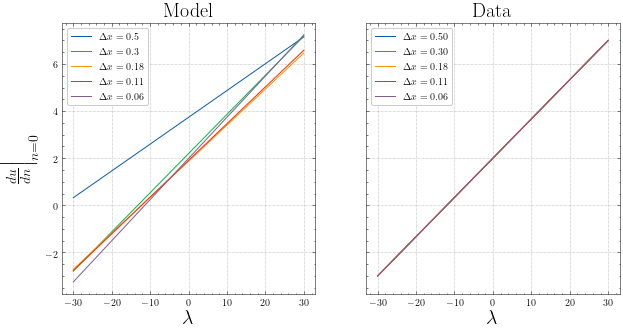

In [18]:
fig,ax = plt.subplots(1,2,figsize =(10,5),sharey=True)
ax[0].set_ylabel(r'$\frac{du}{dn}\Big|_{n=0}$',fontsize=20)
ax[0].set_xlabel(r'$\lambda$', rotation=0,fontsize=20)
ax[1].set_xlabel(r'$\lambda$', rotation=0,fontsize=20)

x = np.array([1 / 10**n for n in np.linspace(0.3, 1.2, 5)])
la = np.linspace(-30,30,51)
for dx in x:
    diff_tmp=np.array([]); fd_1_tmp = np.array([]); mod = np.array([]); exact_tmp=np.array([])
    for lam in la:
        eta = np.append(np.arange(-8,dx,dx)[:-1],np.arange(0,8+dx,dx))
        u1_x, u2_x = sm_pol(dx,lam)[np.logical_or(eta == dx, eta == 2*dx)]
        fd = u2_x/(2*dx)
        diff=(u1_x-pol(dx,lam))
        mod = np.append(mod, model([lam,fd,diff]))
        fd_1_tmp = np.append(fd_1_tmp, fd)
        diff_tmp=np.append(diff_tmp,(u1_x-pol(dx,lam)))
        exact_tmp = np.append(exact_tmp, 2+lam/6)
    ax[0].plot(la,mod,label=f'$\Delta x  = {round(dx,2)}$')
    ax[0].set_title('Model',fontsize=20)
    ax[1].plot(la,exact_tmp,label=r'$\Delta x = {:.2f}$'.format(dx))
    ax[1].set_title('Data',fontsize=20)
ax[0].legend()
ax[1].legend()
# plt.savefig('lambda_dependance.png', dpi=800)
plt.show()

In [19]:
dx=0.5
np.log(1/dx)/np.log(10)
10**1.7

50.11872336272722